In [1]:
# 각 시점마다 prediction 예측 후, n차원 형태로 미래 prediction 값을 제공해보자

In [33]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

In [3]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



In [4]:
#model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [6]:
TRAIN_START_DATE = '2009-01-01' #실제 시작 시점은 2010년 0101이나, prediction용 1년치 추가함.
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-05-05'

tickers = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = tickers).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (32481, 8)


In [7]:
tickers = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']

In [8]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = tickers).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (32481, 8)


In [61]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,22.900000,23.709999,22.690001,17.207544,7110000,XLB,4
1,2009-01-02,48.200001,50.669998,48.080002,31.549152,34283700,XLE,4
2,2009-01-02,10.178716,10.406174,9.918765,7.878148,117919090,XLF,4
3,2009-01-02,23.520000,24.420000,23.270000,18.167885,6659500,XLI,4
4,2009-01-02,15.500000,16.070000,15.380000,12.912432,4479800,XLK,4


In [62]:
#종가 기준 Datasetting

data_for_pred = pd.DataFrame(index = range(len(df[df.tic=='XLB'])), columns = tickers)
data_for_pred['date'] = df[df.tic=='XLB'].date.values
for tic in tickers:
    data_for_pred[tic] = df[df.tic==tic].close.values
    
data_for_pred.head() 

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,date
0,17.207544,31.549152,7.878148,18.167885,12.912432,16.372381,17.672310,21.070580,18.663008,2009-01-02
1,17.244049,32.291500,7.747466,18.025711,12.872056,16.440002,17.922132,20.969465,18.580612,2009-01-05
2,17.630985,32.643772,7.871925,18.422297,13.170849,16.196552,17.666365,20.627230,18.893719,2009-01-06
3,17.222149,31.259766,7.461215,17.599194,12.750926,16.034246,17.523596,20.440569,18.143908,2009-01-07
4,17.463070,31.662392,7.430102,17.771301,12.839756,15.824604,17.434381,20.557238,18.251024,2009-01-08


In [63]:
prediction_start_index = data_for_pred[data_for_pred['date'] >= '2010-01-01'].index[0] 
test_start_index = data_for_pred[data_for_pred['date'] >= TRADE_START_DATE].index[0]

print(prediction_start_index)
print(test_start_index)

252
3209


In [64]:
idx_date = data_for_pred['date']
def idx_date_mapper(idx_list):
    date_list = []
    for idx in idx_list:
        date_list.append(idx_date[idx])
    return date_list

idx_date_mapper([0,1,2,3,4])

['2009-01-02', '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08']

In [103]:
data_for_pred = data_for_pred.drop('date',axis=1)
data_for_pred.head()

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
0,17.207544,31.549152,7.878148,18.167885,12.912432,16.372381,17.672310,21.070580,18.663008
1,17.244049,32.291500,7.747466,18.025711,12.872056,16.440002,17.922132,20.969465,18.580612
2,17.630985,32.643772,7.871925,18.422297,13.170849,16.196552,17.666365,20.627230,18.893719
3,17.222149,31.259766,7.461215,17.599194,12.750926,16.034246,17.523596,20.440569,18.143908
4,17.463070,31.662392,7.430102,17.771301,12.839756,15.824604,17.434381,20.557238,18.251024


In [104]:
# Hyperparameters
WINDOW_SIZE = prediction_start_index
FORCAST_SIZE = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_dataset = data_for_pred[:test_start_index]
test_dataset = data_for_pred[test_start_index-WINDOW_SIZE:]

print(len(train_dataset),len(test_dataset))

3209 652


In [105]:
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual 
        
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])                
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        return x.permute(0,2,1)

In [106]:
class Windowed_Dataset(Dataset):
    def __init__(self, data, window_size, forcast_size):
        self.data = data
        self.window_size = window_size
        self.forcast_size = forcast_size
        
    def __len__(self):
        return len(self.data) - self.window_size - self.forcast_size
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx:idx+self.window_size].values).type(torch.FloatTensor), torch.from_numpy(self.data[idx+self.window_size:idx+self.window_size+self.forcast_size].values).type(torch.FloatTensor)
    

In [107]:
WD_train = Windowed_Dataset(train_dataset, WINDOW_SIZE, FORCAST_SIZE)
WD_test = Windowed_Dataset(test_dataset, WINDOW_SIZE, FORCAST_SIZE)
WD_all = Windowed_Dataset(data_for_pred, WINDOW_SIZE, FORCAST_SIZE)

train_loader = DataLoader(WD_train, batch_size=32, shuffle=False)
test_loader = DataLoader(WD_test, batch_size=32, shuffle=False)
all_loader = DataLoader(WD_all, batch_size=32, shuffle=False)

print(len(WD_train), len(WD_test), len(WD_all))

2927 370 3327


In [94]:
model = LTSF_DLinear(WINDOW_SIZE, FORCAST_SIZE, 25, True, 9)
model = model.to(device)

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, device, epochs, tolerance=0.0001):
    model.train()
    train_loss = 0
    for epoch in tqdm(range(epochs)):
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        if epoch % 10 == 0:
            print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, loss.item()))
        if train_loss < tolerance:
            print('Training Loss: {:.6f}'.format(loss.item()))
            break
        train_loss = 0
            
    return model
            
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    predictions = []
    for X, y in tqdm(test_loader):
        X = X.to(device)
        y = y.to(device)
        with torch.no_grad():
            output = model(X)
            loss = criterion(output, y)
            test_loss += loss.item()
            predictions.append(output)
        
    print('Test Loss: {:.6f}'.format(loss.item()))
    return predictions
         

In [95]:
model = train(model, train_loader, criterion, optimizer, device, 200, 1)

  0%|          | 1/200 [00:01<03:39,  1.10s/it]

Epoch: 1 	Training Loss: 48.092880


  6%|▌         | 11/200 [00:17<05:40,  1.80s/it]

Epoch: 11 	Training Loss: 186.506180


 10%|█         | 21/200 [00:35<05:17,  1.77s/it]

Epoch: 21 	Training Loss: 163.156982


 16%|█▌        | 31/200 [00:52<04:48,  1.71s/it]

Epoch: 31 	Training Loss: 121.314445


 20%|██        | 41/200 [01:09<04:27,  1.68s/it]

Epoch: 41 	Training Loss: 103.263954


 26%|██▌       | 51/200 [01:26<04:10,  1.68s/it]

Epoch: 51 	Training Loss: 105.252213


 30%|███       | 61/200 [01:44<04:04,  1.76s/it]

Epoch: 61 	Training Loss: 133.130432


 36%|███▌      | 71/200 [02:01<03:37,  1.69s/it]

Epoch: 71 	Training Loss: 153.583694


 40%|████      | 81/200 [02:18<03:17,  1.66s/it]

Epoch: 81 	Training Loss: 141.068588


 46%|████▌     | 91/200 [02:35<03:07,  1.72s/it]

Epoch: 91 	Training Loss: 89.904167


 50%|█████     | 101/200 [02:53<02:54,  1.77s/it]

Epoch: 101 	Training Loss: 94.598763


 56%|█████▌    | 111/200 [03:11<02:30,  1.70s/it]

Epoch: 111 	Training Loss: 143.742859


 60%|██████    | 121/200 [03:28<02:20,  1.77s/it]

Epoch: 121 	Training Loss: 110.144958


 66%|██████▌   | 131/200 [03:45<01:59,  1.73s/it]

Epoch: 131 	Training Loss: 110.277969


 70%|███████   | 141/200 [04:05<01:43,  1.75s/it]

Epoch: 141 	Training Loss: 142.697952


 76%|███████▌  | 151/200 [04:23<01:23,  1.70s/it]

Epoch: 151 	Training Loss: 118.973763


 80%|████████  | 161/200 [04:40<01:06,  1.71s/it]

Epoch: 161 	Training Loss: 113.188026


 86%|████████▌ | 171/200 [04:57<00:49,  1.71s/it]

Epoch: 171 	Training Loss: 102.765373


 90%|█████████ | 181/200 [05:14<00:31,  1.68s/it]

Epoch: 181 	Training Loss: 124.313179


 96%|█████████▌| 191/200 [05:33<00:18,  2.07s/it]

Epoch: 191 	Training Loss: 137.110931


100%|██████████| 200/200 [05:51<00:00,  1.76s/it]


In [96]:
test_predictions = test(model, test_loader, criterion, device)

100%|██████████| 12/12 [00:00<00:00, 50.96it/s]

Test Loss: 797.752197


In [97]:
test_predictions = torch.cat(test_predictions, dim=0)
test_predictions.shape

torch.Size([370, 30, 9])

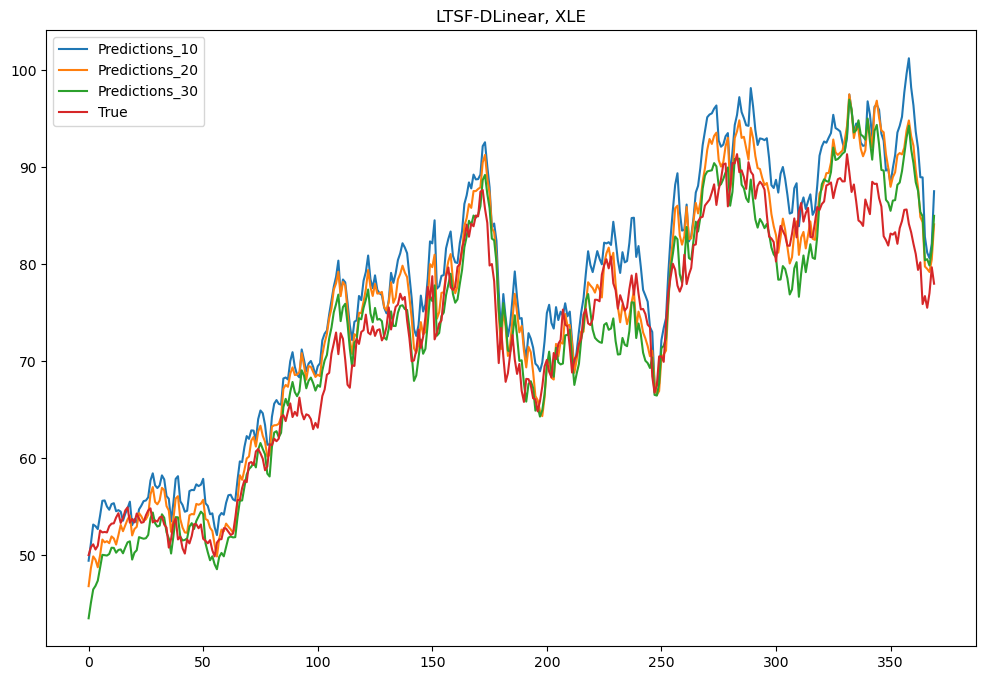

In [98]:
plt.figure(figsize=(12,8))
plt.title('LTSF-DLinear, XLE')
for i in range(9,30,10):
    plt.plot(test_predictions[:,i,1].cpu().detach().numpy(), label='Predictions_{}'.format(i+1))
plt.plot(test_dataset['XLE'].values[WINDOW_SIZE:-FORCAST_SIZE], label='True')
plt.legend()
plt.show()

#### Data 뽑기


In [99]:
print(len(data_for_pred)-WINDOW_SIZE-FORCAST_SIZE)

3327


In [100]:
data_for_pred['date'] = idx_date_mapper(data_for_pred.index)

In [101]:
data_for_pred

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,date
0,17.207544,31.549152,7.878148,18.167885,12.912432,16.372381,17.672310,21.070580,18.663008,2009-01-02
1,17.244049,32.291500,7.747466,18.025711,12.872056,16.440002,17.922132,20.969465,18.580612,2009-01-05
2,17.630985,32.643772,7.871925,18.422297,13.170849,16.196552,17.666365,20.627230,18.893719,2009-01-06
3,17.222149,31.259766,7.461215,17.599194,12.750926,16.034246,17.523596,20.440569,18.143908,2009-01-07
4,17.463070,31.662392,7.430102,17.771301,12.839756,15.824604,17.434381,20.557238,18.251024,2009-01-08
...,...,...,...,...,...,...,...,...,...,...
3604,80.156860,84.386719,33.021828,99.601707,150.514740,76.894493,68.429596,132.982590,147.563187,2023-04-28
3605,80.117058,83.435097,32.932236,100.139557,150.604538,76.954063,68.548637,133.669754,146.106110,2023-05-01
3606,79.340866,79.807060,32.185585,99.093742,149.197479,76.745544,67.715340,133.092133,146.255814,2023-05-02
3607,78.465157,78.300323,31.817236,98.715256,147.940125,76.119987,67.526855,132.912888,145.098145,2023-05-03


In [108]:
all_predictions = test(model, all_loader, criterion, device)
all_predictions = torch.cat(all_predictions, dim=0)
all_predictions.shape

100%|██████████| 104/104 [00:00<00:00, 142.37it/s]

Test Loss: 983.351807


torch.Size([3327, 30, 9])

In [109]:
prediction_5 = pd.DataFrame(all_predictions[:,4,:], columns=tickers, index = (data_for_pred.index[WINDOW_SIZE:-FORCAST_SIZE]))
prediction_10 = pd.DataFrame(all_predictions[:,9,:], columns=tickers, index = (data_for_pred.index[WINDOW_SIZE:-FORCAST_SIZE]))
prediction_30 = pd.DataFrame(all_predictions[:,29,:], columns=tickers, index = (data_for_pred.index[WINDOW_SIZE:-FORCAST_SIZE]))

In [112]:
prediction_5.head()

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
252,24.808691,43.465008,9.345718,25.776966,23.978970,19.316423,21.047405,26.344728,29.322948
253,25.623768,44.595493,9.553405,25.920429,24.381214,19.540195,21.139866,26.814619,29.591909
254,26.020880,44.926476,9.816154,25.986450,24.629982,19.469889,20.883881,26.585705,29.762642
255,26.226303,44.695282,9.781052,25.606930,24.167477,19.282375,20.886683,26.705002,29.325682
256,26.024481,44.574814,9.853897,25.457603,23.991039,19.045454,20.708771,26.487020,29.206799


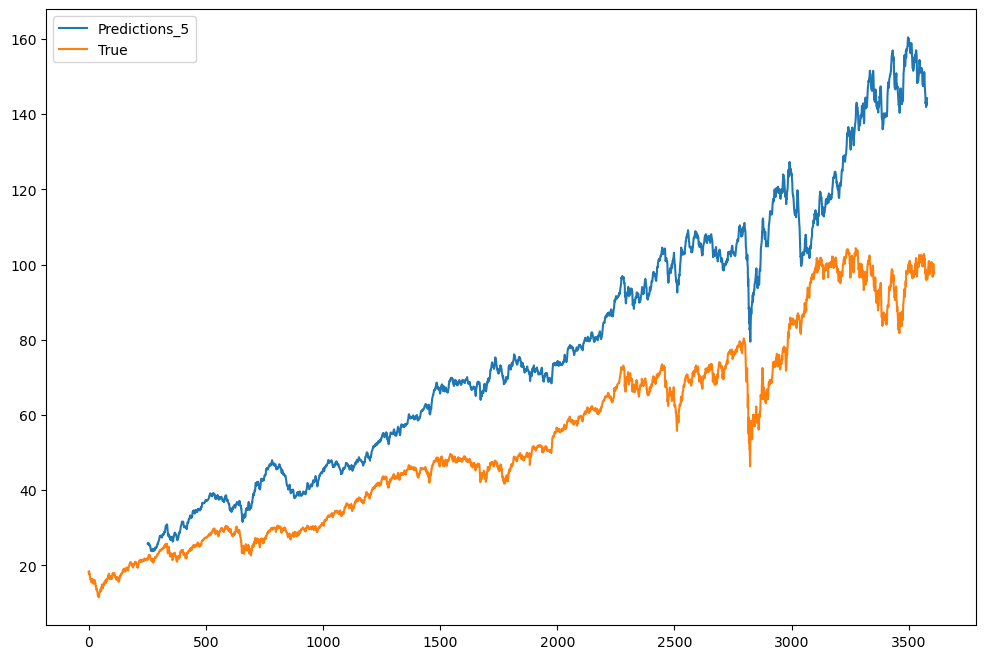

In [116]:
prediction_5['XLI'].plot(figsize=(12,8), label='Predictions_5')
data_for_pred['XLI'].plot(label='True')
plt.legend()

In [118]:
prediction_5.to_csv('prediction_5.csv')
prediction_10.to_csv('prediction_10.csv')
prediction_30.to_csv('prediction_30.csv')